#import every needed Library 


In [ ]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 5.0 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=cdf5a8d07959cc2c021b5df915f401d97f28eb770d3d57ceee4158292830f31a
  Stored in directory: /root/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect


In [ ]:
import nltk
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings
from langdetect import detect

pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
print(tf.__version__)

2.9.2


#loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/ML/project2/test_listings_text.pkl', 'rb') as f:
    data = pickle.load(f) 

In [ ]:
CURR_PATH = !pwd
# PARAMETERS
PATH_DATA = CURR_PATH[0]
PATH_GDRIVE_TMP = "/content/drive/MyDrive/ML/project2"  # Google Drive

In [ ]:
data['Listing Title'].head(2)

In [ ]:
data['Listing Description'].head(2)

In [ ]:
data['Listing Description'] .head(2)

##detect language 

In [ ]:
def detect2(x):
  try:
    return detect(x)
  except:
    return None

de    8212
fr    1554
it     234
Name: Description Langage, dtype: int64

##loading train listing

In [ ]:
import pickle
import pandas as pd
with open('/content/drive/MyDrive/ML/project2/listings.pkl', 'rb') as f:
    data = pickle.load(f) 
#combine description
data['Listing Description'] = data['Listing Title'] + '.' + data['Listing Description']
i = data['Listing Description'].isna()
data.loc[i,'Listing Description']= data.loc[i,'Listing Title']

In [ ]:
#language classify
data['Description Langage']=data['Listing Description'].apply(lambda x: detect2(x))
print(len(data))
#save data with language tag
pickle.dump(data, open(PATH_GDRIVE_TMP + "/data_with_language.pkl", "wb"))
data['Description Langage'].value_counts ()

###for building model

In [ ]:
# data = pickle.load(open(PATH_GDRIVE_TMP+"/data_with_language.pkl", "rb"))
data_de = data.loc[data['Description Langage'] == 'de', ("Listing Description","Listing Title","Demand")]
data_fr = data.loc[data['Description Langage'] == 'fr', ("Listing Description","Listing Title","Demand")]
data_it = data.loc[data['Description Langage'] == 'it', ("Listing Description","Listing Title","Demand")]
print("de1:",len(data_de))
data_de = data_de[data_de["Listing Description"].apply(len)>100]
print(len(data_de))
print("de2:",len(data_de))
print(len(data_it))
print(len(data_de)+len(data_fr)+len(data_it))

de1: 16361
16323
de2: 16323
425
19954


In [ ]:
data_de.columns = ['description', 'title', 'demand']
data_fr.columns = ['description', 'title', 'demand']
data_it.columns = ['description', 'title', 'demand']
df_de, val_data_de = train_test_split(data_de, test_size=0.2, random_state=30)
df_fr, val_data_fr = train_test_split(data_fr, test_size=0.2, random_state=30)
df_it, val_data_it = train_test_split(data_it, test_size=0.2, random_state=30)
print(df_de.head(2))
print(df_fr.head(2))
print(df_it.head(2))

##loading test listing

In [ ]:
import pickle
import pandas as pd
with open('/content/drive/MyDrive/ML/project2/test_listings_overall.pkl', 'rb') as f:
    data = pickle.load(f) 
data = pickle.load(open(PATH_GDRIVE_TMP+"/test_overall_data_with_language.pkl", "rb"))
data['Listing Description'] = data['Listing Title'] + '.' + data['Listing Description']
i = data['Listing Description'].isna()
data.loc[i,'Listing Description']= data.loc[i,'Listing Title']

In [ ]:
data['Description Langage']=data['Listing Description'].apply(lambda x: detect2(x))
print(len(data))
pickle.dump(data, open(PATH_GDRIVE_TMP + "/test_data_with_language.pkl", "wb"))
data['Description Langage'].value_counts ()

###for testing

In [ ]:
# data = pickle.load(open(PATH_GDRIVE_TMP+"/test_overall_data_with_language.pkl", "rb"))
data_de = data.loc[data['Description Langage'] == 'de', ("Listing Description","Listing Title","Prediction")]
data_fr = data.loc[data['Description Langage'] == 'fr', ("Listing Description","Listing Title","Prediction")]
data_it = data.loc[data['Description Langage'] == 'it', ("Listing Description","Listing Title","Prediction")]
print("before filter:",len(data_de))
data_de = data_de[data_de["Listing Description"].apply(len)>100]
print(len(data_fr))
print("after filter:",len(data_de))
print(len(data_it))
print(len(data_de)+len(data_fr)+len(data_de))

In [ ]:
data_de.columns = ['description', 'title', 'Prediction']
data_fr.columns = ['description', 'title', 'Prediction']
data_it.columns = ['description', 'title', 'Prediction']
df_de = data_de
df_fr = data_fr
df_it = data_it
print(df_de.head(2))
print(df_fr.head(2))
print(df_it.head(2))

#data processing 

##clean1
*   Converting text to lower-case
*   Standardising representations of a same entity such as “€”, “euro” and “euros” or “m2” and “m²”
*   Cleaning out certain patterns that are unlikely to be meaningful such as URLs, phone numbers, emails and bank account references.



In [ ]:
import re
def treat_euro(text):
    text = re.sub(r'(euro[^s])|(euros)|(€)', ' euros', text)
    return text
def treat_m2(text):
    text = re.sub(r'(m2)|(m²)', ' m²', text)
    return text

In [ ]:
def filter_ibans(text):
    pattern = r'fr\d{2}[ ]\d{4}[ ]\d{4}[ ]\d{4}[ ]\d{4}[ ]\d{2}|fr\d{20}|fr[ ]\d{2}[ ]\d{3}[ ]\d{3}[ ]\d{3}[ ]\d{5}'
    text = re.sub(pattern, '', text)
    return text
def remove_space_between_numbers(text):
    text = re.sub(r'(\d)\s+(\d)', r'\1\2', text)
    return text
def filter_emails(text):
    pattern = r'(?:(?!.*?[.]{2})[a-zA-Z0-9](?:[a-zA-Z0-9.+!%-]{1,64}|)|\"[a-zA-Z0-9.+!% -]{1,64}\")@[a-zA-Z0-9][a-zA-Z0-9.-]+(.[a-z]{2,}|.[0-9]{1,})'
    text = re.sub(pattern, '', text)
    return text
def filter_ref(text):
    pattern = r'(\(*)(ref|réf)(\.|[ ])\d+(\)*)'
    text = re.sub(pattern, '', text)
    return text
def filter_websites(text):
    pattern = r'(http\:\/\/|https\:\/\/)?([a-z0-9][a-z0-9\-]*\.)+[a-z][a-z\-]*'
    text = re.sub(pattern, '', text)
    return text
def filter_phone_numbers(text):
    pattern = r'(?:(?:\+|00)33[\s.-]{0,3}(?:\(0\)[\s.-]{0,3})?|0)[1-9](?:(?:[\s.-]?\d{2}){4}|\d{2}(?:[\s.-]?\d{3}){2})|(\d{2}[ ]\d{2}[ ]\d{3}[ ]\d{3})'
    text = re.sub(pattern, '', text)
    return text
def filter_tag(text):
    pattern = r'<[^>]+>'
    text = re.sub(pattern, '', text)
    return text

In [ ]:
def clean_text(text):
    text = text.lower()
    text = text.replace(u'\xa0', u' ')
    text = treat_m2(text)
    text = treat_euro(text)
    text = filter_phone_numbers(text)
    text = filter_emails(text)
    text = filter_ibans(text)
    text = filter_ref(text)
    text = filter_websites(text)
    text = remove_space_between_numbers(text)
    text = filter_tag(text)
    return text
df_de['cleaned_description'] = df_de.description.apply(clean_text)

In [ ]:
df_de

##clean2
only in case of dealing stop word (which is not necessary in this task

###for french

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("french")
stop_words = set(stopwords.words("french"))


def clean_text_fr(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

df_fr['cleaned_description'] = df_fr.description.apply(clean_text_fr)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


###for Italian

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("italian")
stop_words = set(stopwords.words("italian"))


def clean_text_it(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

df_it['cleaned_description'] = df_it.description.apply(clean_text_it)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


###for german

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))

def clean_text_de(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

df_de['cleaned_description'] = df_de.description.apply(clean_text_de)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!pip install translate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install -U deep-translator

In [ ]:
from translate import Translator
to_lang="fr"
translator = Translator(to_lang=to_lang)
df_it['description'] = translator.translate(df_it['description'].to_string())


In [ ]:
it = df_it['cleaned_description']

In [ ]:
df_fr = df_fr.append(df_it)

In [ ]:
df_it.head(2)

description  \
0  MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  17 HOURS 11 MINUTES 41 SECONDS VISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  17 HOURS 11 MINUTES 35 SECONDS VISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  17 HOURS 11 MINUTES 35 SECONDS VISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  17 HOURS 11 MINUTES 33 SECONDS VISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  17 HOURS 11 MINUTES 31 SECONDS VISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  17 HOURS 11 MINUTES 30 SECONDS VISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  17 HOURS 11 MINUTES 28 SECONDS VISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  17 HOURS 11 MINUTES 25 SECONDS VISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  17 HOURS 11 MINUTES 16 SECONDS VISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  17 HOURS 11 MINUTES 14 SECONDS VISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIM

#German model

##Tokenization

In [ ]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.8 MB/s 
     |████████████████████████████████| 182 kB 85.8 MB/s 
     |████████████████████████████████| 7.6 MB 65.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.9 MB/s 


In [ ]:
from transformers import BertTokenizer, TFBertModel

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

Downloading:   0%|          | 0.00/255k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')
encoded_corpus = tokenizer(text=df_de.cleaned_description.tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=300,
                            return_attention_mask=True)
input_ids = encoded_corpus['input_ids']
attention_mask = encoded_corpus['attention_mask']

In [ ]:
len(input_ids)

13058

###for building model

In [ ]:
import numpy as np
def filter_long_descriptions(tokenizer, descriptions, max_len):
    indices = []
    lengths = tokenizer(descriptions, padding=False, 
                     truncation=False, return_length=True)['length']
    for i in range(len(descriptions)):
        if lengths[i] <= max_len-2:
            indices.append(i)
    return indices
short_descriptions = filter_long_descriptions(tokenizer, 
                               df_de.cleaned_description.tolist(), 300)
input_ids = np.array(input_ids)[short_descriptions]
attention_mask = np.array(attention_mask)[short_descriptions]
labels = df_de.demand.to_numpy()[short_descriptions]

Token indices sequence length is longer than the specified maximum sequence length for this model (569 > 512). Running this sequence through the model will result in indexing errors


###for testing dataset

In [ ]:
import numpy as np
def filter_long_descriptions(tokenizer, descriptions, max_len):
    indices = []
    lengths = tokenizer(descriptions, padding=False, 
                     truncation=False, return_length=True)['length']
    for i in range(len(descriptions)):
        if lengths[i] <= max_len-2:
            indices.append(i)
    return indices
short_descriptions = filter_long_descriptions(tokenizer, 
                               df_de.cleaned_description.tolist(), 300)
input_ids = np.array(input_ids)[short_descriptions]
attention_mask = np.array(attention_mask)[short_descriptions]

##Input formatting

###for model

In [ ]:
from sklearn.model_selection import train_test_split
test_size = 0.0001
seed = 42
train_inputs, test_inputs, train_labels, test_labels = \
            train_test_split(input_ids, labels, test_size=test_size, 
                             random_state=seed)
train_masks, test_masks, _, _ = train_test_split(attention_mask, 
                                        labels, test_size=test_size, 
                                        random_state=seed)

###for test

In [ ]:
train_inputs = input_ids
train_masks = attention_mask

##create_dataloaders

###dataloader for training model


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
batch_size = 32
def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor, 
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            shuffle=True)
    return dataloader
train_dataloader = create_dataloaders(train_inputs, train_masks, 
                                      train_labels, batch_size)

###dataloader for testing dataset

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
batch_size = 32
def create_dataloaders(inputs, masks, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    dataset = TensorDataset(input_tensor, mask_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            shuffle=True)
    return dataloader
train_dataloader = create_dataloaders(train_inputs, train_masks, batch_size)

###with test_dataloader

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
batch_size = 32
def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor, 
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            shuffle=True)
    return dataloader
train_dataloader = create_dataloaders(train_inputs, train_masks, 
                                      train_labels, batch_size)
test_dataloader = create_dataloaders(test_inputs, test_masks, 
                                     test_labels, batch_size)

##Implementing the model in PyTorch

In [ ]:
import torch.nn as nn
from transformers import BertModel
class BertRegressor(nn.Module):
    
    def __init__(self, drop_rate=0.2):
        
        super(BertRegressor, self).__init__()
        D_in, D_out = 768, 1
        self.Bert = \
                   BertModel.from_pretrained('bert-base-german-cased')
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(D_in, D_out))
    def forward(self, input_ids, attention_masks):
        
        outputs = self.Bert(input_ids, attention_masks)
        class_label_output = outputs[1]
        outputs = self.regressor(class_label_output)
        return outputs
model = BertRegressor(drop_rate=0.2)

Downloading:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##Setting up the training environment

In [ ]:
import torch
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
model.to(device)

Using GPU.


BertRegressor(
  (Bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

##Optimizer, scheduler and loss function

In [ ]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr=5e-5,
                  eps=1e-8)

In [ ]:
from transformers import get_linear_schedule_with_warmup
epochs = 30
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,       
                 num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
loss_function = nn.MSELoss()
# loss_function = nn.PoissonNLLLoss()

##Training loop

In [ ]:
from torch.nn.utils.clip_grad import clip_grad_norm
def train(model, optimizer, scheduler, loss_function, epochs,       
          train_dataloader, device, clip_value=2):
    for epoch in range(epochs):
        print(epoch)
        print("-----")
        best_loss = 1e10
        model.train()
        for step, batch in enumerate(train_dataloader):  
            batch_inputs, batch_masks, batch_labels = \
                               tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)           
            loss = loss_function(outputs.squeeze().float(), 
                             batch_labels.squeeze().float())
            print(f'step:{step}, loss:{loss}') 
            loss.backward()
            clip_grad_norm(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()
                
    return model
model = train(model, optimizer, scheduler, loss_function, epochs, 
              train_dataloader, device, clip_value=2)

Streaming output truncated to the last 5000 lines.
step:123, loss:182.42529296875
step:124, loss:216.08663940429688
step:125, loss:249.96258544921875
step:126, loss:29.198301315307617
step:127, loss:55.558990478515625
step:128, loss:240.7830810546875
step:129, loss:133.007080078125
step:130, loss:553.751708984375
step:131, loss:50.759456634521484
step:132, loss:34.23454666137695
step:133, loss:67.90618896484375
step:134, loss:100.80609893798828
step:135, loss:142.29544067382812
step:136, loss:53.247676849365234
step:137, loss:73.38996887207031
step:138, loss:19.991769790649414
step:139, loss:71.67697143554688
step:140, loss:26.482393264770508
step:141, loss:52.480979919433594
step:142, loss:142.80465698242188
step:143, loss:84.02981567382812
step:144, loss:323.5472412109375
step:145, loss:246.22850036621094
step:146, loss:63.99395751953125
step:147, loss:8136.80859375
step:148, loss:60.8900146484375
step:149, loss:83.83916473388672
step:150, loss:551.5324096679688
step:151, loss:43.984

#Performance

In [ ]:
def predict(model, dataloader, device):
    model.eval()
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks, _ = \
                                  tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += model(batch_inputs, 
                            batch_masks).view(1,-1).tolist()[0]
    return output

def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [ ]:
val_set = val_data_fr[['description', 'demand']]
val_set['cleaned_description'] = \
                val_set.description.apply(clean_text)
encoded_val_corpus = \
                tokenizer(text=val_set.cleaned_description.tolist(),
                          add_special_tokens=True,
                          padding='max_length',
                          truncation='longest_first',
                          max_length=300,
                          return_attention_mask=True)
val_input_ids = np.array(encoded_val_corpus['input_ids'])
val_attention_mask = np.array(encoded_val_corpus['attention_mask'])
val_labels = val_set.demand.to_numpy()
# val_labels = price_scaler.transform(val_labels.reshape(-1, 1))
val_dataloader = create_dataloaders(val_input_ids, 
                         val_attention_mask, val_labels, batch_size)
# y_pred_scaled = predict(model, val_dataloader, device)
y_pred = predict(model, val_dataloader, device)
y_test = val_set.demand.to_numpy()

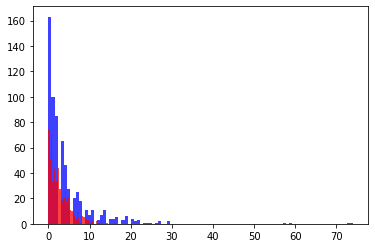

In [ ]:
import matplotlib.pyplot as plt
# n = data["comment_clean"].str.len()
nn, bins, patches = plt.hist(y_test,100, facecolor ='b', alpha=0.75)
nn, bins, patches = plt.hist(pred,50, facecolor ='r', alpha=0.75)
plt.show()

###mean pisson deviance

In [ ]:
def custom_poisson_deviance(y_true,y_pred):
  prediction=y_pred.copy()
  prediction = np.array(prediction)
  prediction[np.where(prediction<=0)]=1e-10
  return mean_poisson_deviance(y_true, prediction)
from sklearn.metrics import mean_poisson_deviance
custom_poisson_deviance(y_test, y_pred)

#test listing prediction

In [ ]:
def predict(model, dataloader, device):
    model.eval()
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks = \
                                  tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += model(batch_inputs, 
                            batch_masks).view(1,-1).tolist()[0]
    return output

def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2
y_pred = predict(model, train_dataloader, device)

In [ ]:
df_de["Prediction"] = y_pred

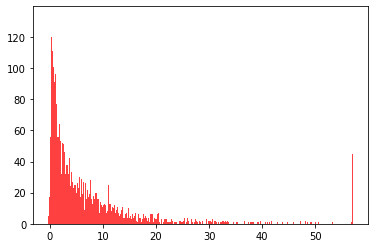

In [ ]:
import matplotlib.pyplot as plt
nn, bins, patches = plt.hist(y_pred,1000, facecolor ='r', alpha=0.75)
plt.show()

#fill data


In [ ]:
data = pd.read_csv(PATH_GDRIVE_TMP + "/test_overall_data_with_prediction_WN.csv")
# data = pd.read_csv(PATH_GDRIVE_TMP + "/test_overall_data_with_prediction_NN.csv")

In [ ]:
data.loc[df_de.index, "Prediction"] = df_de["Prediction"]

In [ ]:
pickle.dump(data, open(PATH_GDRIVE_TMP + "/test_data_with_prediction_WN.pkl", "wb"))
data.to_csv(PATH_GDRIVE_TMP+"/test_overall_data_with_prediction_WN.csv", index=False)

In [ ]:
# pickle.dump(data, open(PATH_GDRIVE_TMP + "/test_overall_data_with_prediction_NN.pkl", "wb"))
# data.to_csv(PATH_GDRIVE_TMP+"/test_overall_data_with_prediction_NN.csv", index=False)

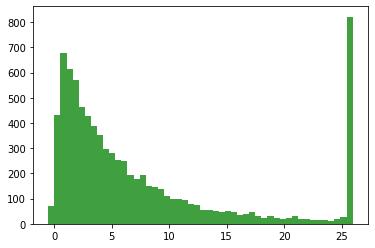

In [ ]:
import matplotlib.pyplot as plt
# n = data["comment_clean"].str.len()
nn, bins, patches = plt.hist(y_pred, 50, facecolor ='g', alpha=0.75)
plt.show()